
# DP-ERM Programming Assignment — Output vs Objective vs Gradient Perturbation

**Goal:** Empirically show how strong convexity (lambda), dimension (d), and dataset size (n) affect the privacy–utility tradeoff.  
**Mechanisms:** Output perturbation, Objective perturbation, Gradient perturbation (full-batch DP-GD).

# Dataset loader and important ML functions (Do Not Edit)

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.model_selection import train_test_split


sns.set_theme(style="whitegrid")
sns.set_palette("tab10")
def seed_all(seed=42):
    import random, os
    random.seed(seed); np.random.seed(seed)
seed_all(7)

def load_dataset(which="breast_cancer", n=None, d=None, test_size=0.3, seed=0):
    rng = np.random.RandomState(seed)
    if which == "breast_cancer":
        data = load_breast_cancer()
        X = data.data.astype(float)
        y = data.target.astype(int)
        y = np.where(y==1, 1, -1)
    else:
        n_total = 600 if n is None else max(n, 20)
        d_raw = 40 if d is None else max(d, 40)
        X = rng.normal(size=(n_total, d_raw))
        wtrue = rng.normal(size=d_raw)
        wtrue /= (np.linalg.norm(wtrue)+1e-12)
        logits = X @ wtrue #+ 0.25 * rng.normal(size=n_total)
        y = np.where(logits >= 0, 1, -1)

    X = (X - X.mean(axis=0, keepdims=True)) / (X.std(axis=0, keepdims=True)+1e-12)

    if d is not None and d < X.shape[1]:
        U,S,Vt = np.linalg.svd(X, full_matrices=False)
        X = X @ Vt[:d].T

    if n is not None and n < X.shape[0]:
        idx = rng.permutation(X.shape[0])[:n]
        X = X[idx]
        y = y[idx]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

    def clip_rows(X, clip_norm=1.0):
        norms = np.linalg.norm(X, axis=1, keepdims=True)+1e-12
        scale = np.minimum(1.0, clip_norm/norms)
        return X*scale

    X_train = clip_rows(X_train, 1.0)
    X_test  = clip_rows(X_test, 1.0)
    return X_train, y_train, X_test, y_test

def sigmoid(z): 
    return 1.0/(1.0+np.exp(-z))

def logistic_grad(w, X, y):
    z = y*(X@w)
    g = -(y[:,None]*X)/(1.0+np.exp(z))[:,None]
    return g.mean(axis=0)

def risk(w, X, y, lam):
    p = sigmoid(X@w)
    y01 = (y>0).astype(float)
    loss = log_loss(y01, p, labels=[0,1])
    return loss

def train_baseline_gd(X, y, lam, steps=2000, lr=0.1, seed=0):
    w = np.zeros(X.shape[1])
    for _ in range(steps):
        g = logistic_grad(w, X, y) + lam*w
        w -= lr*g
    return w


# Utilities for metrics (Do not edit)

In [4]:
from dataclasses import dataclass
from typing import Dict, Any, List

@dataclass
class MetricSummary:
    mean: float
    lower: float
    upper: float
    std: float
    n: int

def ci_mean(x, alpha=0.05):
    """
    Utility to compute mean and confidence intervals
    x: array-like of values
    alpha: significance level (default 0.05 for 95% CI)
    """
    x = np.array(x, dtype=float)
    m = x.mean() 
    s = x.std(ddof=1) if x.size>1 else 0.0
    from math import sqrt
    try:
        from statistics import NormalDist
        z = NormalDist().inv_cdf(1-alpha/2)
    except Exception:
        z = 1.96 if abs(alpha-0.05) < 1e-6 else 1.96
    half = z * s/np.sqrt(x.size) if x.size>1 else 0.0
    return MetricSummary(mean=m, lower=m-half, upper=m+half, std=s, n=x.size)

def aggregate_seed_results(df: pd.DataFrame, group_cols: List[str], metric: str, alpha=0.05):
    """
    Utility to aggregate results over random seeds.
    df: dataframe with results
    group_cols: columns to group by (e.g. method, eps, lam)
    metric: metric column to aggregate (e.g. excess_risk, test_acc)
    alpha: significance level for confidence intervals (default 0.05 for 95% CI)
    """
    rows = []
    if df.empty:
        return pd.DataFrame(columns=group_cols + [f"{metric}_mean", f"{metric}_lo", f"{metric}_hi", f"{metric}_std", "num_seeds"])
    for keys, sub in df.groupby(group_cols):
        stats = ci_mean(sub[metric].values, alpha=alpha)
        if not isinstance(keys, tuple):
            keys = (keys,)
        row = {col: val for col,val in zip(group_cols, keys)}
        row.update({f"{metric}_mean": stats.mean,
                    f"{metric}_lo": stats.lower,
                    f"{metric}_hi": stats.upper,
                    f"{metric}_std": stats.std,
                    "num_seeds": stats.n})
        rows.append(row)
    return pd.DataFrame(rows)

## Output Perturbation (Q1)

In [10]:

# ----- Output Perturbation (TODO) -----
def output_perturbation(w_hat, n, lam, eps, delta, L=100., rng=None):
    """
    Implement the output perturbation mechanism to privatise w_hat.
    n: number of samples
    lam: regularization parameter
    eps, delta: approx DP privacy parameter
    L: Lipschitz constant of the loss function
    rng: random number generator (optional)
    
    Output: private weights
    """
    return None


## Objective Perturbation (Q2)

In [11]:

# ----- Objective Perturbation (TODO) -----
def sample_spherical_laplace(eps_alpha, d, rng):
    """
    Sample from spherical Laplace distribution in d dimensions with
    parameter eps_alpha.
    Output: vector of shape (d,) sampled from exp(-eps_alpha*||x||_2)
    """
    u = rng.normal(size=d); u /= (np.linalg.norm(u)+1e-12)
    r = rng.gamma(shape=d, scale=1.0/eps_alpha)
    return r*u

def train_objective_perturbed(X, y, lam, eps, L=100., steps=5000, lr=0.01, seed=0):
    """
    Implement the objective perturbation mechanism to privatise the ERM.
    X, y: data
    lam: regularization parameter
    eps: privacy parameter
    L: Lipschitz constant of the loss function
    steps: number of GD steps to solve the perturbed objective
    lr: learning rate to use in GD to solve the perturbed objective
    Use sample_spherical_laplace() to get sample the noise vector
    Use logistic_grad() to compute gradients of the logistic loss
    
    Output: private weights
    """
    
    return None

## Gradient Perturbation (Q3)

In [4]:

# ----- Gradient Perturbation (Full-batch DP-GD; TODO) -----
def zcdp_sigma_for_gd(eps, delta, T, Delta):
    """
    Use this function to compute the Gaussian noise sigma to use in each iteration of DP-GD
    to ensure (eps, delta)-DP after T steps.
    This uses zCDP composition.
    eps, delta: approx DP privacy parameters
    T: number of steps
    Delta: sensitivity of the average gradient
    """
    a = np.log(1.0/delta)
    t = -np.sqrt(a) + np.sqrt(a+eps)
    rho = max(1e-18, t**2)
    return Delta*np.sqrt(T/(2.0*rho))

def train_gradient_perturbed_gd(X, y, lam, eps, delta, steps=200, lr=0.1, L=100., seed=0):
    """
    Train a gradient-perturbed model using DP-GD.
    X, y: data
    lam: regularization parameter
    eps, delta: approx DP privacy parameters
    steps: number of GD steps
    lr: learning rate
    L: Lipschitz constant of the loss function
    Use zcdp_sigma_for_gd() to compute the sigma to use in each iteration
    Use logistic_grad() to compute gradients of the logistic loss

    Output private weight, and noise magnitude used in each iteration
    """
    
    return None, None


## Experiment & Plotting Scaffolding (Q4, set Liptschitz_L)

* Add the right Lipschitz parameter here and argue in the hand-in why that is correct
* If you want to pass different learning rate, or compute additional metrics for each run, edit them here

In [37]:

def run_all_mechanisms(X_train, y_train, X_test, y_test, lam, eps, delta, steps_dpgd=2500, steps_output_gd=2500, steps_objective_gd=2500, seed=0):
    """
    Run all mechanisms (baseline, output, objective, gradient perturbation)
    and return the results in a dictionary.

    X_train, y_train: training data
    X_test, y_test: test data
    lam: regularization parameter
    eps, delta: approx DP privacy parameters
    steps_dpgd: number of steps for DP-GD
    steps_output_gd: number of steps for GD to solve the
    output-perturbed objective
    steps_objective_gd: number of steps for GD to solve the
    objective-perturbed objective
    seed: random seed
    """

    LIPSCHITZ_L=100. # Change this

    w0 = train_baseline_gd(X_train, y_train, lam=lam, steps=steps_output_gd, lr=0.1, seed=seed)
    base_risk = risk(w0, X_train, y_train, lam)

    w_out = output_perturbation(w0.copy(), n=X_train.shape[0], lam=lam, eps=eps, delta=delta, L=LIPSCHITZ_L,
                                rng=np.random.RandomState(seed+1))
    w_obj = train_objective_perturbed(X_train, y_train, lam=lam, eps=eps, L=LIPSCHITZ_L,
                                                 steps=steps_objective_gd, lr=0.1, seed=seed+2)
    w_gd, sigma_g = train_gradient_perturbed_gd(X_train, y_train, lam=lam, eps=eps, delta=delta,
                                                steps=steps_dpgd, lr=0.2, seed=seed+3)

    results = {
        "baseline": {"w": w0, "train_risk": base_risk},
        "output":   {"w": w_out},
        "objective":{"w": w_obj},
        "grad":     {"w": w_gd, "sigma_g": sigma_g},
    }
    return results

def summarize(results, X_train, y_train, lam):
    R0 = results["baseline"]["train_risk"]
    out = {}
    for k in ["output","objective","grad"]:
        wk = results[k]["w"]
        Rk = risk(wk, X_train, y_train, lam)
        out[k] = dict(excess_risk=np.abs(Rk-R0))
    return out


# Code for sweeping

* In the following cell, there is a dummy code for sweeping over some epsilon and some lambda.
* You will have to add more functions here for sweeping over other parameters that you want to plot with respect to.
* All sweeping codes should be added in this cell

In [7]:

def sweep_eps_for_lams(X_train, y_train, X_test, y_test, lams, eps_list, delta, steps_dpgd=250, steps_output_gd=250, steps_objective_gd=250, seed=0, mech="output", seeds=None):
    """Return long-form DataFrame across lambdas, epsilons, and seeds."""
    records = []
    if seeds is None:
        seeds = [seed]
    for lam in lams:
        for eps in eps_list:
            for s in seeds:
                R = run_all_mechanisms(X_train, y_train, X_test, y_test, lam=lam, eps=eps, delta=delta, steps_dpgd=steps_dpgd, steps_output_gd=steps_output_gd, steps_objective_gd=steps_objective_gd,  seed=s)
                S = summarize(R, X_train, y_train, lam=lam)
                rec = {"lambda": lam, "epsilon": eps, "seed": s}
                rec.update(S[mech])
                records.append(rec)
    return pd.DataFrame(records)

## Plot (Below is an example code to plot epsilon vs excess risk)

Keep this style of plots.

In [38]:
sns.color_palette("tab10")


def demo_run():
    # Configuration
    seeds = list(range(5))  # number of seeds for CI
    Xtr, ytr, Xte, yte = load_dataset(which="breast_cancer", n=None, d=20, seed=22)
    delta = 1e-5
    eps_fixed = 2
    eps_list = [0.5, 1.0, 2.0, 5.0]
    lams = [1e-3, 1e-2, 1e-1, 1.0,]

    for mech in ["output", "objective", "grad"]:
        df_eps = sweep_eps_for_lams(Xtr, ytr, Xte, yte, lams, eps_list, delta, mech=mech, seeds=seeds)
        # Aggregate per lambda, epsilon
        agg = aggregate_seed_results(df_eps, ["lambda","epsilon"], "excess_risk")
        
        plt.figure(figsize=(6,4))
        sns.lineplot(data=agg, x="epsilon", y="excess_risk_mean", hue="lambda", marker='o', ms=14, palette='tab10', linewidth=4)
        for (lam), sub in agg.groupby("lambda"):
            plt.fill_between(sub["epsilon"], sub["excess_risk_lo"], sub["excess_risk_hi"], alpha=0.12)
        plt.title(f"{mech.capitalize()} perturbation", fontsize=18)
        plt.ylabel("Excess Risk", fontsize=16)
        plt.xlabel("Epsilon", fontsize=16)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


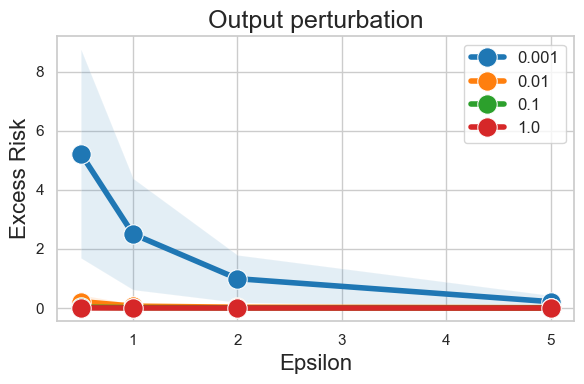

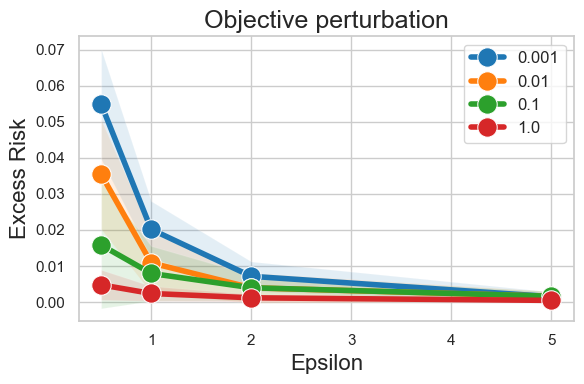

In [ ]:
res_data = demo_run()
# With our solution of the two algorithms (that has now been deleted)